In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV

<h1>Overview</h1>
In this notebook, I will attempt to predict the quality of wine using the features in winequality-red.csv which I got from kaggle.

<h1> Load in data </h1>
First, lets load in the data, and normalize it

In [2]:
# read in csv wine file
df_unnorm = pd.read_csv('winequality-red.csv')
df_unnorm.head()

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df =(df_unnorm-df_unnorm.min())/(df_unnorm.max()-df_unnorm.min())
df.head()

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.4
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,0.4
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,0.4
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,0.6
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.4


<h1>Plots</h1>
Now, let's plot the features against quality

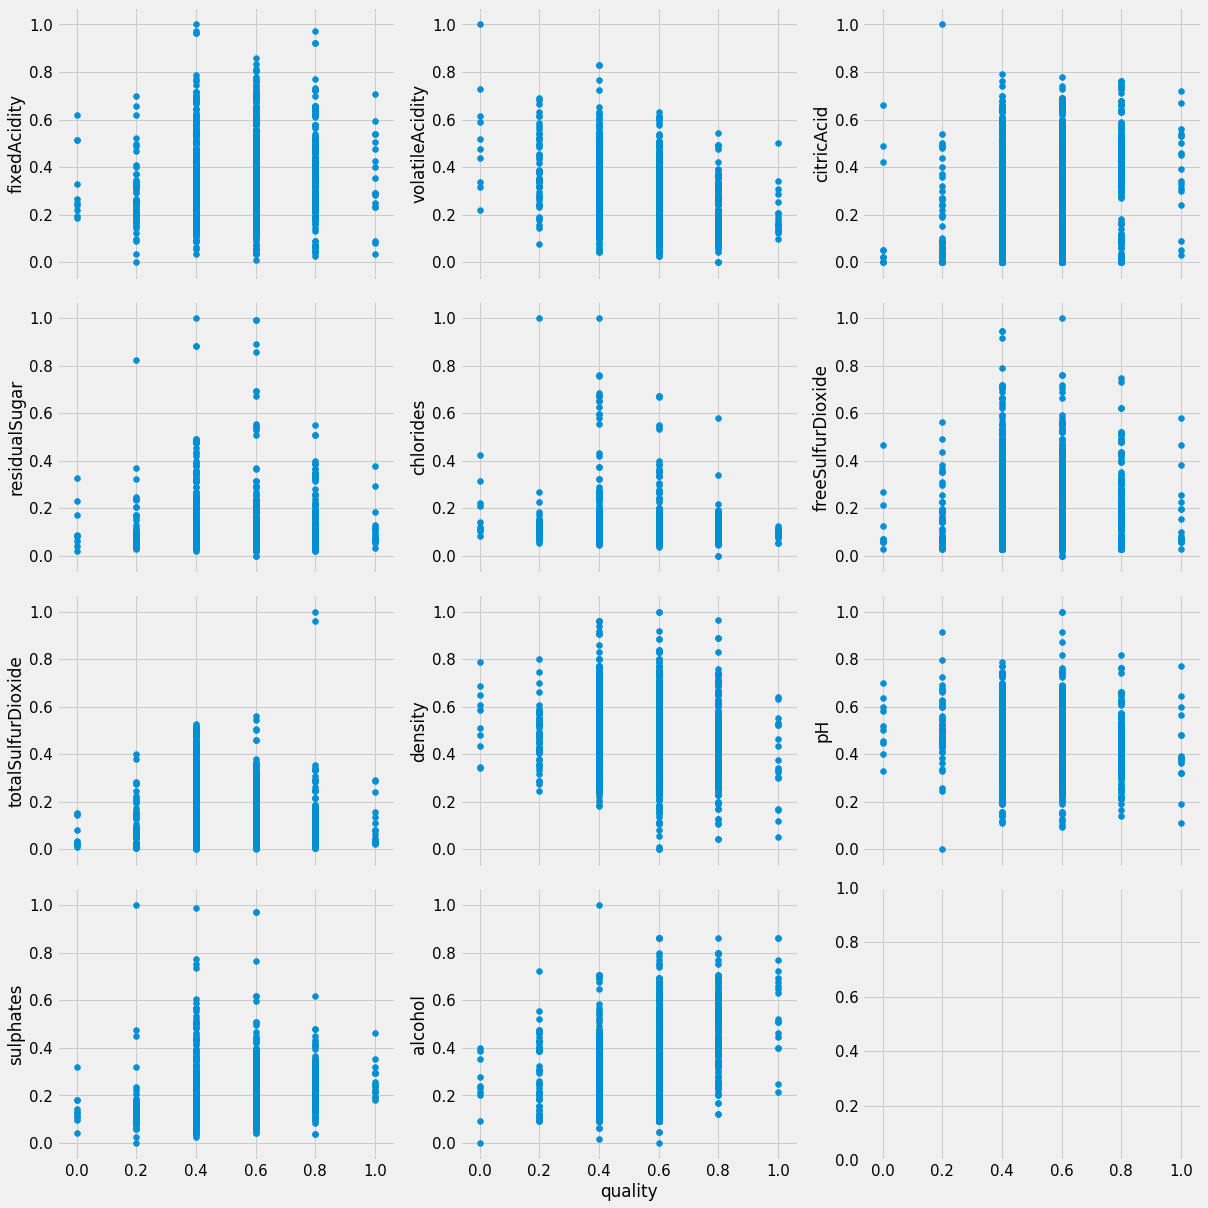

In [4]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15) 
plt.style.use('fivethirtyeight')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(nrows = 4, ncols = 3,
                                                                                            figsize = (17,17),
                                                                                           sharex = True)
plt.subplots_adjust(wspace = 1, hspace = 1)

subplots = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11)
features = list(df)

for i in range(0,11):
    subplots[i].scatter(df['quality'], df[features[i]])
    subplots[i].set_ylabel(features[i])

ax11.set_xlabel('quality')

fig.tight_layout()
plt.show()

<h1> Analysis</h1>
Now, I will take a look at the data and the correlations between features and our target variable

<h3> Correlated Features </h3>
First of all, we should remove correlated features as this may affect our data. For this particular case, we will select two features having a higher than 0.6 or lower than -0.6 correlation as correlated

In [5]:
list_features = list(features)
list_features
corr_features = []
# small function to loop through all features and check if they are correlated, with a 'cutoff' of 0.5
for i in range(0,11):
    for j in range(i,11):
        if i != j:
            ijcor = df[[list_features[i], list_features[j]]].corr().iloc[0,1]
            if ijcor > .6 or ijcor < -.6:
                corr_features.append((list_features[i], list_features[j], ijcor))
                
corr_features

[('fixedAcidity', 'citricAcid', 0.6717034347641083),
 ('fixedAcidity', 'density', 0.6680472921189747),
 ('fixedAcidity', 'pH', -0.6829781945685359),
 ('freeSulfurDioxide', 'totalSulfurDioxide', 0.6676664504810224)]

It looks like there are quite a few correlated features. We can 'fix' this by dropping fixedAcidity and freeSulfurDioxide

In [6]:
df = df.drop(columns = ['fixedAcidity', 'freeSulfurDioxide'])
df.head()

,volatileAcidity,citricAcid,residualSugar,chlorides,totalSulfurDioxide,density,pH,sulphates,alcohol,quality
0,0.397260,0.00,0.068493,0.106845,0.098940,0.567548,0.606299,0.137725,0.153846,0.4
1,0.520548,0.00,0.116438,0.143573,0.215548,0.494126,0.362205,0.209581,0.215385,0.4
2,0.438356,0.04,0.095890,0.133556,0.169611,0.508811,0.409449,0.191617,0.215385,0.4
3,0.109589,0.56,0.068493,0.105175,0.190813,0.582232,0.330709,0.149701,0.215385,0.6
4,0.397260,0.00,0.068493,0.106845,0.098940,0.567548,0.606299,0.137725,0.153846,0.4


<h3>Statsmodel</h3>
Now, lets take a look at how our features work together to predict the quality variable

In [7]:
features = df.drop(columns = ['quality'])
target = df['quality']

model = sm.OLS(target, features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                quality   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              2423.
Date:                Thu, 20 Feb 2020   Prob (F-statistic):                        0.00
Time:                        02:32:50   Log-Likelihood:                          832.78
No. Observations:                1599   AIC:                                     -1648.
Df Residuals:                    1590   BIC:                                     -1599.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
volatileAcidity       -0.1394      0.037     -3.743      0.000      -0.212      -0.066
citricAcid             0.0772      0.030      2.583      0.010       0.019       0.136
residualSugar         -0.1205      0.043     -2.813      0.005      -0.205      -0.036
chlorides             -0.0507      0.053     -0.952      0.341      -0.155       0.054
totalSulfurDioxide    -0.0027      0.033     -0.082      0.935      -0.067       0.061
density                0.3746      0.034     10.943      0.000       0.307       0.442
pH                     0.2545      0.030      8.427      0.000       0.195       0.314
sulphates              0.3509      0.042      8.383      0.000       0.269       0.433
alcohol                0.6150      0.029     21.112      0.000       0.558       0.672
==============================================================================
Omnibus:                       53.447   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.009
Skew:                          -0.299   Prob(JB):                     5.73e-19
Kurtosis:                       3.950   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a very high R_squared score, but this could be an error due to numerous factors since our plots don't exactly look linear.<br>
From the above, it seems like chlorides and totalSulfurDioxide don't affect the quality too much (from the p-value cutoff of < 0.05).
<br><br>
Lets double check using the pearson correlation heatmap

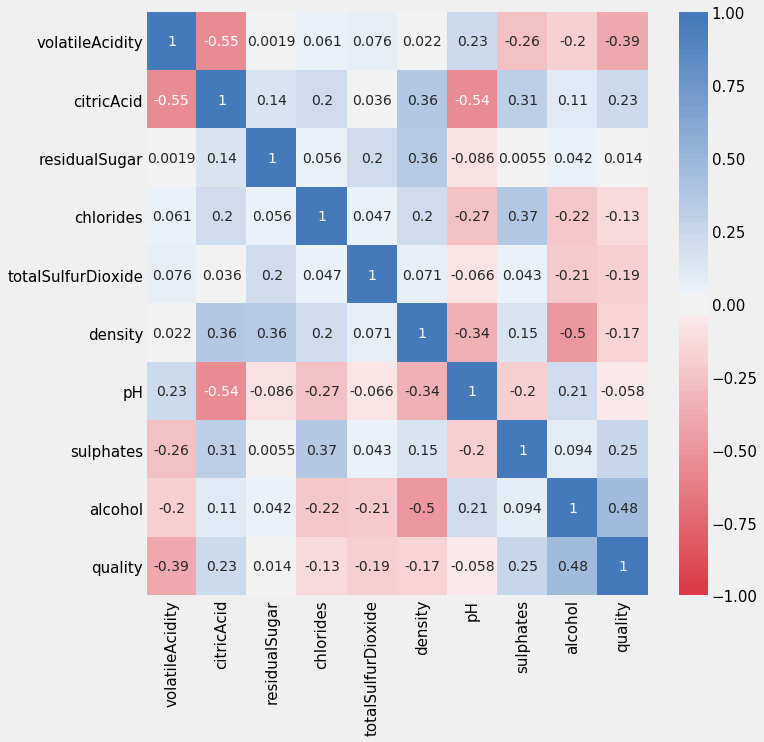

In [8]:
#Using Pearson Correlation
plt.figure(figsize=(10,10))
cor = df.corr()
sns.heatmap(cor, 
            annot=True, 
            cmap=sns.diverging_palette(10,250, n = 100),
           vmin = -1, vmax = 1, center = 0)
plt.show()

Now that we have our correlation heatmap, let's take a look at the correlations corresponding to quality

In [9]:
cor_quality = cor['quality']
cor_quality[(cor_quality < -.3) | (cor_quality > .3)]

volatileAcidity   -0.390558
alcohol            0.476166
quality            1.000000
Name: quality, dtype: float64

The heatmap tells us that only volatileAcidity and alcohol are correlated with quality (with a 'cutoff' of abs(0.3)). This is perhaps because features seem to have different relationships with quality when compared by themselves (heatmap) and as a whole (linear model).

<h1>Modelling</h1>
Well since we are not too sure which set of features to use, why dont we create two models, one dealing with all but chlorides and totalSulfurDioxide, and the other dealing with only volatileAcidity and alcohol, and compare them?
<br><br>
note: we will refer to the 'all but chlorides and totalSulfurDioxides' model as statsmodel, and the 'volatileAcidity and alcohol' model as heatmap

In [10]:
# split into train test sets
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns = ['quality']),
                                                    df.quality,train_size=0.99)

In [11]:
x_sm_train = x_train.drop(columns = ['chlorides', 'totalSulfurDioxide'])
x_sm_test = x_test.drop(columns = ['chlorides', 'totalSulfurDioxide'])
x_heat_train = x_train[['volatileAcidity','alcohol']]
x_heat_test = x_test[['volatileAcidity','alcohol']]

In [12]:
print('Length of x_sm_train: {}\nLength of x_sm_test: {}\nLength of x_heat_train:{}\nLength of x_heat_test:{}'
     .format(len(x_sm_train), len(x_sm_test), len(x_heat_train), len(x_heat_test)))

Length of x_sm_train: 1583
Length of x_sm_test: 16
Length of x_heat_train:1583
Length of x_heat_test:16


In [13]:
lm_sm = LinearRegression()
lm_heat = LinearRegression()
model_sm = lm_sm.fit(x_sm_train, y_train)
model_heat = lm_heat.fit(x_heat_train, y_train)

In [14]:
print('Statsmodel test score: {}\nHeat test score:{}'
     .format(lm_sm.score(x_sm_test,y_test), lm_heat.score(x_heat_test, y_test)))

Statsmodel test score: 0.5143652087284996
Heat test score:0.4761310364444284


Seems like neither model is working well, which makes sense as our plots werent very linear in the first place. Lets try a bit more and see if there are perhaps some feature combinations we are missing.

<h1>Embedded Method</h1>
Lets use the sklearn LassoCV to implement the embedded method, to determine which features fit best.

In [15]:
lasso = LassoCV()
lasso.fit(x_train,y_train)

/home/uumuunnuu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [16]:
best_score = lasso.score(x_test, y_test)
print('Our best score given by lasso is:{}'.format(best_score))

Our best score given by lasso is:0.5676289824188163


Looks like our data isn't really meant to be modelled with a linear model. Let's take a look at the most important features as defined by lasso.

In [17]:
coef = pd.Series(lasso.coef_, index = list(features))
coef

volatileAcidity      -0.308713
citricAcid           -0.005518
residualSugar         0.000000
chlorides            -0.180685
totalSulfurDioxide   -0.111238
density              -0.000000
pH                   -0.094767
sulphates             0.262856
alcohol               0.378294
dtype: float64

As we also concluded, it looks like alcohol and volatileAcidity are the most important features. That said, even they arent too great at linearly predicting wine quality.

<h1>Conclusion</h1>
In this notebook, I got to practice various linear analysis, as well as linear modelling. While I got to try out a lot of things, it really seems like wine quality can't be predicted linearly. Perhaps another model will work. Maybe I'll come back to this dataset with another apporoach some time in the future.